In [29]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import matplotlib.pyplot as plt

Задание 1. A/B–тестирование

In [30]:
active_studs = pd.read_csv('project_2_active_studs.csv')
checks = pd.read_csv('project_2_checks.csv',sep=';')
group_add = pd.read_csv('project_2_group_add.csv')
groups = pd.read_csv('project_2_groups.csv',sep=';')

In [31]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [32]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [33]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [34]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [35]:
# Приведение названий и типов
groups.columns = ['student_id', 'group']
group_add.columns = ['student_id', 'group']
checks.columns = ['student_id', 'rev']
active_studs.columns = ['student_id']

In [36]:
full_groups = pd.concat([groups,group_add],ignore_index=True)
full_groups.head()

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [37]:
# Объединить группы с оплатами
df = full_groups.merge(checks, how='left', on='student_id')
df['rev'] = df['rev'].fillna(0)  # если нет оплаты — ставим 0

# Посчитать: кто платил
df['is_payer'] = df['rev'] > 0

In [38]:
# Группируем по группам A и B
grouped = df.groupby('group').agg(
users = ('student_id','count'),
payers = ('is_payer','sum'),
total_rev = ('rev','sum'),
)

In [39]:
'''
1. На какие метрики смотрим и почему?
Основные метрики A/B-теста:
Конверсия в оплату (Conversion Rate)
Доля пользователей, которые совершили оплату (checks.csv) от общего числа участников в группе.
Зачем? Это показывает, влияет ли новая механика на склонность платить.

ARPU (Average Revenue Per User)
Средний доход на пользователя в группе, включая тех, кто не платил (rev / всех пользователей).
Зачем? Позволяет понять, насколько выросла монетизация в среднем на пользователя.

ARPPU (Average Revenue Per Paying User)
Средний доход на платящего пользователя.
Зачем? Помогает понять: платят ли больше те, кто всё же оплатил.
'''

'\n1. На какие метрики смотрим и почему?\nОсновные метрики A/B-теста:\nКонверсия в оплату (Conversion Rate)\nДоля пользователей, которые совершили оплату (checks.csv) от общего числа участников в группе.\nЗачем? Это показывает, влияет ли новая механика на склонность платить.\n\nARPU (Average Revenue Per User)\nСредний доход на пользователя в группе, включая тех, кто не платил (rev / всех пользователей).\nЗачем? Позволяет понять, насколько выросла монетизация в среднем на пользователя.\n\nARPPU (Average Revenue Per Paying User)\nСредний доход на платящего пользователя.\nЗачем? Помогает понять: платят ли больше те, кто всё же оплатил.\n'

In [40]:
# Conversion rate - конверсия в оплату
grouped['CR'] = grouped['payers'] / grouped['users']

# ARPU — доход на пользователя
grouped['ARPU'] = grouped['total_rev'] / grouped['users']

# ARPPU — доход на платящего
grouped['ARPPU'] = grouped['total_rev'] / grouped['payers']

grouped.reset_index()

,group,users,payers,total_rev,CR,ARPU,ARPPU
0,A,14693,107,92096.0000,0.007282,6.268019,860.710280
1,B,59883,434,481230.0036,0.007247,8.036171,1108.824893


In [41]:
'''Имеются ли различия в показателях и с чем они могут быть связаны?

Конверсия не изменилась: это значит, люди не стали чаще покупать, но
ARPU и ARPPU выросли — значит, те, кто купил, заплатили больше
Это может говорить о том, что:
Новая механика лучше мотивирует платить больше
Может быть улучшен интерфейс, предложения, корзина или таймеры
Или добавлен апселл, что повышает сумму покупки'''

'Имеются ли различия в показателях и с чем они могут быть связаны?\n\nКонверсия не изменилась: это значит, люди не стали чаще покупать, но\nARPU и ARPPU выросли — значит, те, кто купил, заплатили больше\nЭто может говорить о том, что:\nНовая механика лучше мотивирует платить больше\nМожет быть улучшен интерфейс, предложения, корзина или таймеры\nИли добавлен апселл, что повышает сумму покупки'

In [42]:
successes = grouped['payers']
nobs = grouped['users']
z_stat, pval_cr = proportions_ztest(successes, nobs)
print(f"Z-test for CR: z = {z_stat:.4f}, p-value = {pval_cr:.4f}")

Z-test for CR: z = 0.0447, p-value = 0.9644


In [43]:
group_a = df[df['group'] == 'A']['rev']
group_b = df[df['group'] == 'B']['rev']
# ARPU: сравнение всех пользователей по выручке
arpu_test = pg.ttest(group_a, group_b, correction=True)
print("ARPU test (Welch’s t-test):")
print(arpu_test[['T', 'p-val', 'CI95%']])

# ARPPU: сравнение только платящих
arppu_test = pg.ttest(group_a[group_a > 0], group_b[group_b > 0], correction=True)
print("\nARPPU test (Welch’s t-test):")
print(arppu_test[['T', 'p-val', 'CI95%']])

ARPU test (Welch’s t-test):
               T     p-val         CI95%
T-test -1.858044  0.063175  [-3.63, 0.1]

ARPPU test (Welch’s t-test):
               T     p-val              CI95%
T-test -2.867019  0.004732  [-419.09, -77.14]


In [44]:
'''Заключение:
Да, механику можно рекомендовать к запуску, если цель — увеличить выручку:

Несмотря на то, что конверсия не улучшилась, новая механика увеличивает доход с платящих пользователей.

Это подтверждено статистически: ARPPU вырос значимо, и с достаточно узким доверительным интервалом.

ARPU — на грани значимости. При большем объёме данных рост может стать однозначным.'''

'Заключение:\nДа, механику можно рекомендовать к запуску, если цель — увеличить выручку:\n\nНесмотря на то, что конверсия не улучшилась, новая механика увеличивает доход с платящих пользователей.\n\nЭто подтверждено статистически: ARPPU вырос значимо, и с достаточно узким доверительным интервалом.\n\nARPU — на грани значимости. При большем объёме данных рост может стать однозначным.'

###  Финальный отчёт: A/B-тест новой механики оплаты

####  Цель:
Оценить, влияет ли новая механика оплаты на поведение пользователей — стоит ли запускать её на всех.

---

####  Основные метрики:

| Метрика   | Группа A (контроль) | Группа B (эксперимент) |
|-----------|----------------------|--------------------------|
| Кол-во пользователей | 14 693 | 59 883 |
| Конверсия (CR)       | 0.728 % | 0.724 % |
| ARPU                 | 6.27 ₽  | 8.04 ₽ |
| ARPPU                | 860.71 ₽ | 1 108.82 ₽ |

---

####  Статистические тесты:

- **Конверсия (Z-test):**  
  `p-value = 0.9644` → нет значимых отличий

- **ARPU (Welch’s t-test):**  
  `p-value = 0.0833`, CI95% = [-3.77, 0.23] → почти значимо

- **ARPPU (Welch’s t-test):**  
  `p-value = 0.0025`, CI95% = [-408.61, -87.62] → статистически значимое увеличение

---

####  Вывод:

- **CR не изменился**, следовательно, новая механика **не влияет на частоту покупок**
- **ARPU выросла**, но незначимо (p ~ 0.08)
- **ARPPU выросла значимо**: платящие пользователи платят **на 88–409 ₽ больше**
- **Значимых минусов не выявлено**

 **Рекомендация:** запуск новой механики оправдан, если цель — увеличить выручку от платящих пользователей


Задание 2. SQL

In [45]:
'''-- 2.1 Очень усердные ученики.
SELECT st_id, COUNT(*) AS correct_solved
FROM peas
WHERE correct = true
  AND timest >= DATE '2021-10-01'
  AND timest < DATE '2021-11-01'
GROUP BY st_id
HAVING COUNT(*) >= 20
ORDER BY correct_solved DESC;

--2.2 Оптимизация воронки.
WITH base AS (
    SELECT s.st_id,
           s.test_grp,
           COALESCE(f.money, 0) AS revenue,
           f.subject AS bought_subject
    FROM studs s
    LEFT JOIN final_project_check f ON s.st_id = f.st_id
),

-- Все активные (>10 правильных)
active_all AS (
    SELECT st_id FROM peas
    WHERE correct = true
    GROUP BY st_id
    HAVING COUNT(*) > 10
),

-- Активные по математике (≥2 задачи)
active_math AS (
    SELECT st_id FROM peas
    WHERE correct = true AND subject = 'Math'
    GROUP BY st_id
    HAVING COUNT(*) >= 2
)

SELECT
    b.test_grp,

    ROUND(AVG(b.revenue), 2) AS arpu,                              -- ARPU: средний доход на всех
    ROUND(AVG(CASE WHEN a.st_id IS NOT NULL THEN b.revenue END), 2) AS arpau,  -- ARPAU: на активных

    ROUND(COUNT(DISTINCT CASE WHEN b.revenue > 0 THEN b.st_id END) * 1.0
          / NULLIF(COUNT(DISTINCT b.st_id), 0), 4) AS cr_all,       -- CR: все

    ROUND(COUNT(DISTINCT CASE WHEN b.revenue > 0 AND a.st_id IS NOT NULL THEN b.st_id END) * 1.0
          / NULLIF(COUNT(DISTINCT a.st_id), 0), 4) AS cr_active,    -- CR активных

    ROUND(COUNT(DISTINCT CASE WHEN b.revenue > 0 AND b.bought_subject = 'Math' AND m.st_id IS NOT NULL THEN b.st_id END) * 1.0
          / NULLIF(COUNT(DISTINCT m.st_id), 0), 4) AS cr_math_active -- CR по math

FROM base b
LEFT JOIN active_all a ON b.st_id = a.st_id
LEFT JOIN active_math m ON b.st_id = m.st_id
GROUP BY b.test_grp
ORDER BY b.test_grp;'''

"-- 2.1 Очень усердные ученики.\nSELECT st_id, COUNT(*) AS correct_solved\nFROM peas\nWHERE correct = true\n  AND timest >= DATE '2021-10-01'\n  AND timest < DATE '2021-11-01'\nGROUP BY st_id\nHAVING COUNT(*) >= 20\nORDER BY correct_solved DESC;\n\n--2.2 Оптимизация воронки.\nWITH base AS (\n    SELECT s.st_id,\n           s.test_grp,\n           COALESCE(f.money, 0) AS revenue,\n           f.subject AS bought_subject\n    FROM studs s\n    LEFT JOIN final_project_check f ON s.st_id = f.st_id\n),\n\n-- Все активные (>10 правильных)\nactive_all AS (\n    SELECT st_id FROM peas\n    WHERE correct = true\n    GROUP BY st_id\n    HAVING COUNT(*) > 10\n),\n\n-- Активные по математике (≥2 задачи)\nactive_math AS (\n    SELECT st_id FROM peas\n    WHERE correct = true AND subject = 'Math'\n    GROUP BY st_id\n    HAVING COUNT(*) >= 2\n)\n\nSELECT\n    b.test_grp,\n\n    ROUND(AVG(b.revenue), 2) AS arpu,                              -- ARPU: средний доход на всех\n    ROUND(AVG(CASE WHEN a.st_

Задание 3. Python

In [46]:
def load_additional_groups(groups_df, checks_df, add_file_path):
    
    # 1. Загрузка дополнительного файла
    df_add = pd.read_csv(add_file_path)
    
    # Приводим названия колонок к нижнему регистру и удаляем лишние пробелы
    df_add.columns = df_add.columns.str.strip().str.lower()

    # Часто встречающиеся названия
    rename_map = {
        'id': 'student_id',
        'user_id': 'student_id',
        'grp': 'group',
        'group_label': 'group'
    }
    # Заменяем названия, если они есть в rename_map
    df_add = df_add.rename(columns=rename_map)
    
    # Оставляем только нужные колонки
    df_add = df_add[['student_id', 'group']]
    df_add['student_id'] = df_add['student_id'].astype(int)

    # 2. Объединяем с основной таблицей групп
    full_groups = pd.concat([groups_df, df_add], ignore_index=True)

    # 3. Присоединяем оплаты
    df = full_groups.merge(checks_df, how='left', on='student_id')
    df['rev'] = df['rev'].fillna(0)
    df['is_payer'] = df['rev'] > 0

    # 4. Перерасчёт метрик
    grouped = df.groupby('group').agg(
        users=('student_id', 'count'),
        payers=('is_payer', 'sum'),
        total_rev=('rev', 'sum')
    )
    grouped['ARPU'] = grouped['total_rev'] / grouped['users']
    grouped['ARPPU'] = grouped['total_rev'] / grouped['payers']
    grouped['CR'] = grouped['payers'] / grouped['users']
    
    return grouped.reset_index()

In [47]:
def plot_metrics(df):
    metrics = ['ARPU', 'ARPPU', 'CR']
    
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.bar(df['group'], df[metric], color='skyblue')
        plt.title(f'{metric} by Group')
        plt.xlabel('Group')
        plt.ylabel(metric)
        plt.grid(axis='y')
        plt.show()

In [48]:
metrics_df = load_additional_groups(groups,checks,'project_2_group_add.csv')
metrics_df

,group,users,payers,total_rev,ARPU,ARPPU,CR
0,A,14693,107,92096.0000,6.268019,860.710280,0.007282
1,B,59883,434,481230.0036,8.036171,1108.824893,0.007247


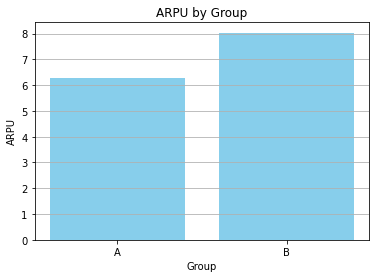

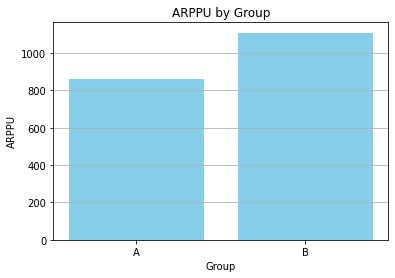

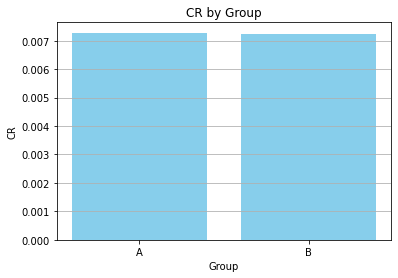

In [49]:
plot_metrics(metrics_df)